In [1]:
import warnings
warnings.filterwarnings('ignore')

import nltk
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt


from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, LSTM, \
    Bidirectional, TimeDistributed, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

%matplotlib inline

In [2]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()
tagged_sentences[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [3]:
sentences, sentence_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(sentence)
    sentence_tags.append(tags)

In [4]:
char_vocab, token_vocab = Counter(), Counter()

for sent in sentences:
    char_vocab.update(''.join(sent).lower())
    tokens = ['<DIGIT>' if word.isdigit() else word.lower() for word in sent]
    token_vocab.update(tokens)

In [5]:
char_vocab = {char for char in char_vocab if char_vocab[char] > 200}
token_vocab = {token for token in token_vocab if token_vocab[token] > 5}

In [6]:
char2id = {'<PAD>': 0, '<UNK>': 1}
token2id = {'<PAD>': 0, '<UNK>': 1}

for i, char in enumerate(char_vocab):
    char2id[char] = i + 2

for i, token in enumerate(token_vocab):
    token2id[token] = i + 2
    
id2char = {i: char for char, i in char2id.items()}
id2token = {i: token for token, i in token2id.items()}

In [7]:
tag2id = {'<PAD>': 0}
for tags in sentence_tags:
    for tag in tags:
        if tag.lower() not in tag2id:
            tag2id[tag.lower()] = len(tag2id)

id2tag = {i: tag for tag, i in tag2id.items()}

In [8]:
X_tokens = [[token2id.get(token, token2id['<UNK>']) for token in sentence] for sentence in sentences]
X_chars = [[[char2id.get(char, char2id['<UNK>']) for char in token]
            for token in sentence] for sentence in sentences]

In [9]:
MAX_SENT_LEN = max(map(len, X_tokens))
MAX_TOKEN_LEN = max(map(len, [token for sent in X_chars for token in sent]))

In [10]:
MAX_SENT_LEN

271

In [11]:
MAX_TOKEN_LEN

24

In [12]:
X_tokens = pad_sequences(X_tokens, maxlen=MAX_SENT_LEN, padding='post')
X_tokens.shape

(3914, 271)

In [13]:
X_chars = pad_sequences([pad_sequences(sent, maxlen=MAX_TOKEN_LEN, padding='post') for sent in X_chars],
                        maxlen=MAX_SENT_LEN, padding='post')
X_chars.shape

(3914, 271, 24)

In [14]:
y = to_categorical(pad_sequences([[tag2id[tag.lower()] for tag in tags] for tags in sentence_tags],
                                 maxlen=MAX_SENT_LEN, padding='post'))
y.shape

(3914, 271, 47)

In [15]:
X_tokens_train, X_tokens_valid, X_chars_train, X_chars_valid, y_train, y_valid = train_test_split(
    X_tokens, X_chars, y, test_size=0.2, random_state=42
)

In [16]:
def build_model(dropout_rate: float = 0.2, l2_rate: float = 0.001, lr: float = 0.001):
    tokens = Input(shape=(MAX_SENT_LEN, ))
    chars = Input(shape=(MAX_SENT_LEN, MAX_TOKEN_LEN))
    
    token_embs = Embedding(len(token2id), 100, mask_zero=True)(tokens)
    token_embs = Dropout(dropout_rate)(token_embs)
    token_encoded = Bidirectional(LSTM(256, return_sequences=True,
                                       kernel_regularizer=regularizers.l2(l2_rate)))(token_embs)
    token_encoded = Dropout(dropout_rate)(token_encoded)
    
    char_embs = Embedding(len(char2id), 30)(chars)
    char_embs = Dropout(dropout_rate)(char_embs)
    char_conv = TimeDistributed(Conv1D(kernel_size=3, filters=32, strides=1, padding='same',
                                       kernel_regularizer=regularizers.l2(l2_rate)))(char_embs)
    char_conv = TimeDistributed(Flatten())(char_conv)
    char_conv = Dropout(dropout_rate)(char_conv)
    
    comb_reprs = Concatenate()([token_encoded, char_conv])
    encoded = Bidirectional(LSTM(256, return_sequences=True,
                                 kernel_regularizer=regularizers.l2(l2_rate)))(comb_reprs)
    
    outputs = TimeDistributed(Dense(len(tag2id), activation='softmax'))(encoded)
    
    model = Model(inputs=[tokens, chars], outputs=outputs)
    model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 271, 24)      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 271)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 271, 24, 30)  1380        input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 271, 100)     196000      input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [18]:
def scheduler(epoch: int) -> float:
    return max(1e-4, 1e-2 * 0.5**(epoch // 10))

callbacks = [
    EarlyStopping(monitor='val_acc', min_delta=0.01, patience=10, verbose=1, mode='max'),
    LearningRateScheduler(scheduler)
]

In [19]:
model.fit([X_tokens_train, X_chars_train], y_train,
          validation_data=([X_tokens_valid, X_chars_valid], y_valid),
          batch_size=256,
          epochs=100,
          callbacks=callbacks
         )

Train on 3131 samples, validate on 783 samples
Epoch 1/100
3131/3131 [==============================] - 39s 12ms/step - loss: 4.9139 - acc: 0.1207 - val_loss: 4.1445 - val_acc: 0.2326
Epoch 2/100
3131/3131 [==============================] - 33s 11ms/step - loss: 3.9346 - acc: 0.3476 - val_loss: 3.3936 - val_acc: 0.4757
Epoch 3/100
3131/3131 [==============================] - 33s 10ms/step - loss: 2.8967 - acc: 0.5305 - val_loss: 2.3622 - val_acc: 0.5674
Epoch 4/100
3131/3131 [==============================] - 33s 10ms/step - loss: 2.0538 - acc: 0.6405 - val_loss: 1.6695 - val_acc: 0.7161
Epoch 5/100
3131/3131 [==============================] - 33s 10ms/step - loss: 1.4731 - acc: 0.7455 - val_loss: 1.2700 - val_acc: 0.7667
Epoch 6/100
3131/3131 [==============================] - 33s 10ms/step - loss: 1.1552 - acc: 0.7908 - val_loss: 0.9911 - val_acc: 0.8312
Epoch 7/100
3131/3131 [==============================] - 33s 10ms/step - loss: 0.9411 - acc: 0.8330 - val_loss: 0.8643 - val_acc: 0

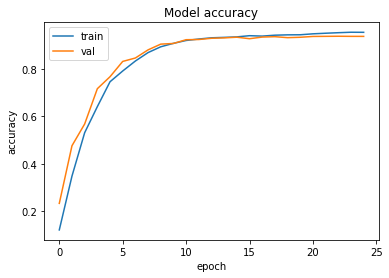

In [21]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper_left')
plt.show()

In [33]:
from typing import List

def inference(sentence: List[str]) -> List[str]:
    token_ids = pad_sequences([[token2id.get(token, token2id['<UNK>']) for token in sentence]],
                              maxlen=MAX_SENT_LEN, padding='post')
    char_ids = pad_sequences([pad_sequences([[char2id.get(char, char2id['<UNK>']) for char in token] for token in sentence],
                                            maxlen=MAX_TOKEN_LEN, padding='post')], maxlen=MAX_SENT_LEN, padding='post')
    preds = np.argmax(model.predict([token_ids, char_ids])[0], axis=-1)
    
    return [id2tag[i] for i, _ in zip(preds, tokens)]

In [35]:
for i in np.random.randint(0, len(sentences), 3):
    sentence = sentences[i]
    preds = inference(sentences[i])
    print('\n'.join(['\t'.join((token, tag)) for token, tag in zip(sentence, preds)]))
    print()

But	cc
Coleco	nnp
bounced	vbd
back	rb
with	in
the	dt
introduction	nn
of	in
the	dt
Cabbage	nnp
Patch	nnp
dolls	nns
,	,
whose	wp$
sales	nns
*T*-1	-none-
hit	vbd

These	dt
funds	nns
now	rb
account	vbp
for	in
several	jj
billions	nns
of	in
dollars	nns
in	in
assets	nns
.	.

``	``
And	cc
as	in
a	dt
leading	vbg
investment	nn
and	cc
merchant	nn
banking	nn
firm	nn
,	,
the	dt
fact	nn
that	in
we	prp
are	vbp
no	rb



Conclusion: the addition of character-level features allowed us to easily train a well-performing model for our task which was completely impossible with only word-level features. Furthermore, using L2 regularization and dropout allowed us to almost completely avoid overfitting.